In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import csv
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
is_cuda = torch.cuda.is_available()

# Si tenemos una GPU disponible, configuraremos nuestro dispositivo en GPU. Usaremos esta variable de dispositivo más adelante en nuestro código.
if is_cuda:
    device = torch.device("cuda")
    print("GPU esta disponible")
else:
    device = torch.device("cpu")
    print("GPU no dispoible, CPU usada")

GPU no dispoible, CPU usada


In [22]:
base_csv = '/content/sample_data/IMDB Dataset.csv'
df = pd.read_csv(base_csv, delimiter=",")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### División para entrenar y probar datos

Dividiremos los datos para entrenar y probar inicialmente. Hacer esto en una etapa anterior permite evitar la fuga de datos.

In [23]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


#### Analizando los sentimientos

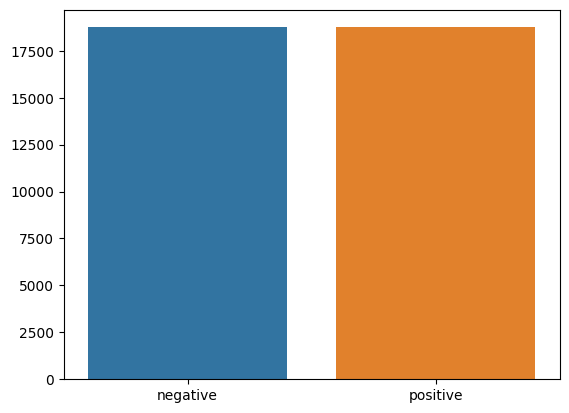

In [25]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

Tockenización

In [26]:
def preprocess_string(s):
    # Eliminar todos los caracteres que no sean palabras (todo excepto números y letras)
    s = re.sub(r"[^\w\s]", '', s)
    # Reemplace todas las tiradas de espacios en blanco sin espacio
    s = re.sub(r"\s+", '', s)
    # reemplazar dígitos sin espacio
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # ordenar según las palabras más comunes
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creando un dictado
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenizar
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [27]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

<ipython-input-26-62691318db9e>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [28]:
print(f'La longitud del vocabulario es {len(vocab)}')

La longitud del vocabulario es 1000


#### Analizando la longitud de los reviews

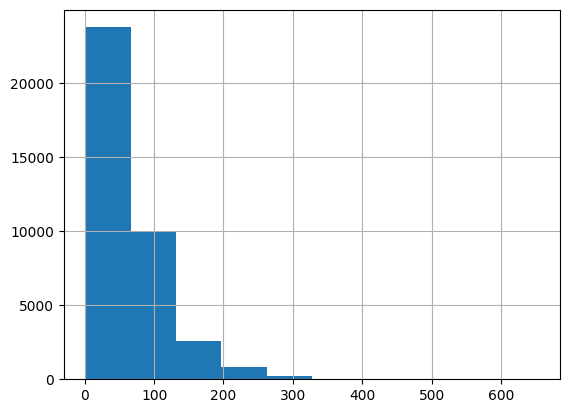

count    37500.000000
mean        69.058533
std         47.840325
min          2.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        652.000000
dtype: float64

In [29]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

#### Rellenando datos

Ahora rellenaremos cada una de las secuencias hasta alcanzar la longitud máxima.

In [30]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [31]:
#Tenemos muy pocas reseñas con una extensión mayor a 500 caracteres.
#Así que consideraremos sólo aquellos que tienen menos de esa cantidad de caracteres
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

#### Procesamiento por lotes y cargando como tensor

In [32]:
# creando conjuntos de datos tensoriales
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# cargadores de datos
batch_size = 50

# mezclando los datos
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [34]:
# obteneniendo un lote de datos de entrenamiento
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Tamaño de muestra de entrada: ', sample_x.size()) # batch_size, seq_length
print('Muestra de entrada: \n', sample_x)
print('Muestra de entrada: \n', sample_y)

Tamaño de muestra de entrada:  torch.Size([50, 500])
Muestra de entrada: 
 tensor([[  0,   0,   0,  ..., 163, 840,   6],
        [  0,   0,   0,  ..., 157,   1,   1],
        [  0,   0,   0,  ...,  44,  55,   2],
        ...,
        [  0,   0,   0,  ..., 608,  85,   2],
        [  0,   0,   0,  ...,  13,  69,   2],
        [  0,   0,   0,  ..., 146, 154, 335]])
Muestra de entrada: 
 tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1])


#### MODELO

In [35]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embeddings y capas LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # capa de dropout
        self.dropout = nn.Dropout(0.3)

        # capa lineal y sigmoidea
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings y lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout y capa completamente conectada
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # función sigmoidea
        sig_out = self.sig(out)

        # remodelar para que sea batch_size primero
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # obtener el último lote de etiquetas

        # devolver la última salida sigmoidea y el estado oculto
        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Crea dos nuevos tensores con tamaños n_layers x batch_size x hidden_dim,
        # inicializado a cero, para estado oculto y estado de celda de LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [38]:
no_layers = 2
vocab_size = len(vocab) + 1 #aumentado en 1 para rellenar
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#Moviendo al gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
